In [1]:
!pip install -q torch==2.8.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --only-binary :all:
!pip install -q transformers accelerate pandas scikit-learn unidecode nltk seaborn tqdm emoji huggingface_hub matplotlib

ERROR: Could not find a version that satisfies the requirement torch==2.8.0 (from versions: 2.1.0+cu121, 2.1.1+cu121, 2.1.2+cu121, 2.2.0+cu121, 2.2.1+cu121, 2.2.2+cu121, 2.3.0+cu121, 2.3.1+cu121, 2.4.0+cu121, 2.4.1+cu121, 2.5.0+cu121, 2.5.1+cu121)
ERROR: No matching distribution found for torch==2.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 

In [2]:
import os, re, random, emoji, nltk, torch, warnings
import numpy as np, pandas as pd, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt, seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, get_cosine_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report # <-- Added import
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

try:
    user_secrets = UserSecretsClient()
    HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
    login(token= HF_TOKEN)
except:
    print("HuggingFace token not found. Running without login.")

nltk.download('punkt')
warnings.filterwarnings("ignore")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
class CFG:
    MODEL_NAME = "vinai/bertweet-base"
    MAX_LEN = 96
    BATCH_SIZE = 32
    NUM_WORKERS = 2
    SEED = 101
    DROPOUT = 0.2
    NUM_EPOCHS = 10
    LR = 2e-5
    WEIGHT_DECAY = 0.01
    NUM_WORKERS = 2
    #SEED = 
    WARMUP_RATIO = 0.1
    R_DROP_ALPHA = 0.3
    LABEL_SMOOTH = 0.1
    GRAD_ACCUM = 1
    FP16 = True
    
    MODEL_INPUT_DIR = "/kaggle/input/logits-ensemble-dataset2/pytorch/default/1/logits ensemble"
    
    MODEL_FILES = [
        "best_model_101.pt", 
        "best_model_5555.pt",
        "best_model_2468.pt",
        "best_model_3141.pt",
        "best_model_90210.pt"
    ]

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(CFG.SEED)

def pre_process_document(text):
    text = re.sub(r"http\\S+|www\\S+|https\\S+", '', text)
    text = emoji.demojize(text)
    text = re.sub(r"@\\w+", "@user", text)
    text = re.sub(r"#(\\w+)", r"\\1", text)
    text = re.sub(r"\\s+", " ", text).strip()
    return text.lower()

In [5]:
train_df = pd.read_csv("/kaggle/input/twitter-emotion-dataset2/train.csv")
val_df   = pd.read_csv("/kaggle/input/twitter-emotion-dataset2/val.csv")
test_df  = pd.read_csv("/kaggle/input/twitter-emotion-dataset2/test.csv")

train_df['text'] = train_df['text'].apply(pre_process_document)
val_df['text']   = val_df['text'].apply(pre_process_document)
test_df['text']  = test_df['text'].apply(pre_process_document)

le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
val_df['label']   = le.transform(val_df['label'])
test_df['label']  = le.transform(test_df['label'])

NUM_CLASSES = train_df['label'].nunique()
CLASS_NAMES = le.classes_
print(f"Detected {NUM_CLASSES} emotion classes: {list(CLASS_NAMES)}")

Detected 6 emotion classes: [0, 1, 2, 3, 4, 5]


In [6]:
tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL_NAME)

class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = df['text'].values
        self.labels = df['label'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = torch.tensor(self.labels[idx]).long()
        enc = self.tokenizer(
            text, truncation=True, padding='max_length',
            max_length=self.max_len, return_tensors='pt'
        )
        return {
            'input_ids': enc['input_ids'].squeeze(),
            'attention_mask': enc['attention_mask'].squeeze(),
            'label': label
        }

train_ds = TweetDataset(train_df, tokenizer, CFG.MAX_LEN)
val_ds   = TweetDataset(val_df, tokenizer, CFG.MAX_LEN)
test_ds  = TweetDataset(test_df, tokenizer, CFG.MAX_LEN)

# Note: train_loader shuffle=False now, as we just need logits in order
train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [7]:
class BERTweetClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(CFG.MODEL_NAME)
        self.dropout = nn.Dropout(CFG.DROPOUT)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        pooled = self.dropout(pooled)
        return self.fc(pooled)

In [8]:
def load_model(model_path):
    # Uses BERTweetClassifier (Cell 7) and NUM_CLASSES (Cell 5)
    model = BERTweetClassifier(NUM_CLASSES)
    checkpoint = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint)
    model.to(DEVICE)
    model.eval()
    return model

seed_models = []
print(f"Loading models from: {CFG.MODEL_INPUT_DIR}")
for file in CFG.MODEL_FILES:
    path = os.path.join(CFG.MODEL_INPUT_DIR, file)
    if os.path.exists(path):
        model = load_model(path)
        seed_models.append(model)
        print(f"✅ Loaded {file}")
    else:
        print(f"⚠️ Missing: {path}") # Print the full path for debugging

print(f"\nTotal models loaded: {len(seed_models)}")

if len(seed_models) == 0:
    raise Exception("No models loaded. Check CFG.MODEL_INPUT_DIR and CFG.MODEL_FILES.")
elif len(seed_models) != len(CFG.MODEL_FILES):
    print("Warning: Not all models specified in CFG.MODEL_FILES were loaded.")

Loading models from: /kaggle/input/logits-ensemble-dataset2/pytorch/default/1/logits ensemble


2025-11-06 16:29:44.360594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762446584.589604      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762446584.652060      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

✅ Loaded best_model_101.pt
✅ Loaded best_model_5555.pt
✅ Loaded best_model_2468.pt
✅ Loaded best_model_3141.pt
✅ Loaded best_model_90210.pt

Total models loaded: 5


In [9]:
@torch.no_grad()
def collect_logits(model, dataset):
    # Uses DataLoader constructor from Cell 6
    loader = DataLoader(dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    model_logits = []
    model.eval()
    
    for batch in tqdm(loader, desc="Collecting logits"):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        
        # Uses forward pass from BERTweetClassifier in Cell 7
        logits = model(input_ids, attention_mask)
        
        model_logits.append(logits.cpu().numpy())
    return np.concatenate(model_logits, axis=0)

all_train_logits = []
all_val_logits = []
all_test_logits = []

print(f"Collecting logits from {len(seed_models)} models. This may take a few minutes...")
for i, m in enumerate(seed_models, start=1):
    print(f" -> Model {i}/{len(seed_models)}")
    
    # Uses dataset names from Cell 6: train_ds, val_ds, test_ds
    tr = collect_logits(m, train_ds)
    va = collect_logits(m, val_ds)
    te = collect_logits(m, test_ds)
    
    # Quick sanity checks
    assert tr.shape[0] == len(train_ds), f"train size mismatch model {i}"
    assert va.shape[0] == len(val_ds), f"val size mismatch model {i}"
    assert te.shape[0] == len(test_ds), f"test size mismatch model {i}"
    
    all_train_logits.append(tr)
    all_val_logits.append(va)
    all_test_logits.append(te)

print("✅ Done collecting logits.")
print(f"Shapes (per model): train {all_train_logits[0].shape}, val {all_val_logits[0].shape}, test {all_test_logits[0].shape}")

 -> Model 1/5


 -> Model 2/5


 -> Model 3/5


 -> Model 4/5


 -> Model 5/5


✅ Done collecting logits.
Shapes (per model): train (52109, 6), val (7445, 6), test (14888, 6)


In [10]:
# Stack the lists of arrays into 3D arrays
# Shape will be (num_models, num_samples, num_classes)
stacked_train_logits = np.stack(all_train_logits)
stacked_val_logits = np.stack(all_val_logits)
stacked_test_logits = np.stack(all_test_logits)

# Average across the models (axis=0)
avg_train_logits = np.mean(stacked_train_logits, axis=0)
avg_val_logits = np.mean(stacked_val_logits, axis=0)
avg_test_logits = np.mean(stacked_test_logits, axis=0)

print("Ensembled Logit Shapes:")
print(f"Train: {avg_train_logits.shape}")
print(f"Val:   {avg_val_logits.shape}")
print(f"Test:  {avg_test_logits.shape}")

Ensembled Logit Shapes:
Train: (52109, 6)
Val:   (7445, 6)
Test:  (14888, 6)


In [11]:
print("Saving ensembled logits to .npy files...")
np.save('/kaggle/working/avg_ensemble_train_logits_dataset2.npy', avg_train_logits)
np.save('/kaggle/working/avg_ensemble_val_logits_dataset2.npy', avg_val_logits)
np.save('/kaggle/working/avg_ensemble_test_logits_dataset2.npy', avg_test_logits)
print("Logits saved successfully to /kaggle/working/")

Saving ensembled logits to .npy files...
Logits saved successfully to /kaggle/working/


In [12]:
# Get hard predictions from averaged logits
train_preds = np.argmax(avg_train_logits, axis=1)
val_preds = np.argmax(avg_val_logits, axis=1)
test_preds = np.argmax(avg_test_logits, axis=1)

# Get true labels (from DataFrames in Cell 5)
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

# Calculate metrics
train_acc = accuracy_score(train_labels, train_preds)
train_f1 = f1_score(train_labels, train_preds, average='weighted')

val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='weighted')

test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print("--- 🚀 Ensemble Evaluation --- ")
print(f"Train Acc: {train_acc:.6f} | Train F1: {train_f1:.6f}")
print(f"Val Acc:   {val_acc:.6f} | Val F1:   {val_f1:.6f}")
print(f"Test Acc:  {test_acc:.6f} | Test F1:  {test_f1:.6f}")

--- 🚀 Ensemble Evaluation --- 
Train Acc: 0.979562 | Train F1: 0.979569
Val Acc:   0.972062 | Val F1:   0.972022
Test Acc:  0.971722 | Test F1:  0.971688


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate general (macro-averaged) metrics for each split
train_precision = precision_score(train_labels, train_preds, average='macro')
train_recall = recall_score(train_labels, train_preds, average='macro')
train_f1 = f1_score(train_labels, train_preds, average='macro')

val_precision = precision_score(val_labels, val_preds, average='macro')
val_recall = recall_score(val_labels, val_preds, average='macro')
val_f1 = f1_score(val_labels, val_preds, average='macro')

test_precision = precision_score(test_labels, test_preds, average='macro')
test_recall = recall_score(test_labels, test_preds, average='macro')
test_f1 = f1_score(test_labels, test_preds, average='macro')

print("--- 📊 General Model Metrics (Macro-Averaged) ---")
print(f"Train → Precision: {train_precision:.6f} | Recall: {train_recall:.6f} | F1: {train_f1:.6f}")
print(f"Val   → Precision: {val_precision:.6f} | Recall: {val_recall:.6f} | F1: {val_f1:.6f}")
print(f"Test  → Precision: {test_precision:.6f} | Recall: {test_recall:.6f} | F1: {test_f1:.6f}")


--- 📊 General Model Metrics (Macro-Averaged) ---
Train → Precision: 0.980100 | Recall: 0.979562 | F1: 0.979569
Val   → Precision: 0.972655 | Recall: 0.972059 | F1: 0.972023
Test  → Precision: 0.972254 | Recall: 0.971724 | F1: 0.971687



--- 🚀 Ensemble Classification Report ---
              precision    recall  f1-score   support

           0     0.9922    0.9722    0.9821      2481
           1     0.9954    0.9549    0.9747      2482
           2     0.9627    0.9976    0.9798      2481
           3     0.9792    0.9690    0.9741      2482
           4     0.9608    0.9375    0.9490      2481
           5     0.9433    0.9992    0.9704      2481

    accuracy                         0.9717     14888
   macro avg     0.9723    0.9717    0.9717     14888
weighted avg     0.9723    0.9717    0.9717     14888


Confusion matrix saved to ensemble_confusion_matrix_dataset2.png


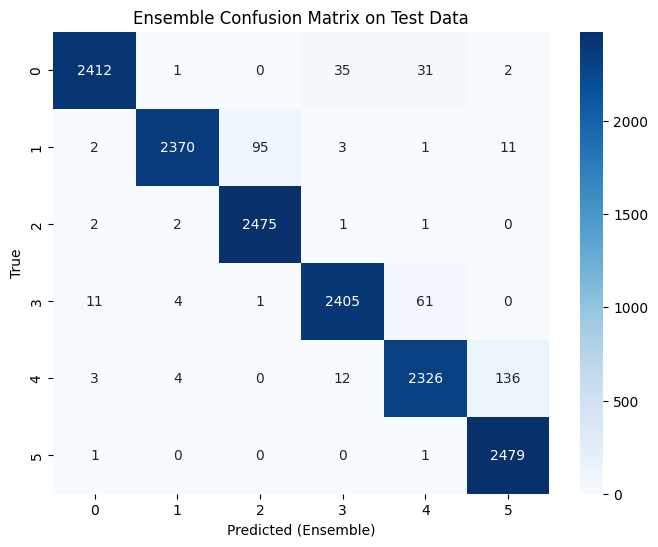

In [14]:
# Cell 13
# *** MODIFIED CELL: Fixed Classification Report and saved plot ***

# --- Classification Report ---
# (Uses test_labels and test_preds from Cell 12, CLASS_NAMES from Cell 5)
print("\n--- 🚀 Ensemble Classification Report ---")
# FIXED: Removed target_names=CLASS_NAMES because CLASS_NAMES is [0, 1, 2, 3, 4, 5]
# The report will now correctly use the numeric labels.
report = classification_report(test_labels, test_preds, digits=4)
print(report)

# --- Confusion Matrix ---
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
# Using fmt=".0f" to show raw counts as integers
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted (Ensemble)")
plt.ylabel("True")
plt.title("Ensemble Confusion Matrix on Test Data")
# Save the figure to the output directory
plt.savefig("ensemble_confusion_matrix_dataset2.png")
print("\nConfusion matrix saved to ensemble_confusion_matrix_dataset2.png")

In [15]:
# Cell 14
# *** NEW CELL: Generate and Save Predictions CSV ***
print("\n" + "="*40)
print(f"💾 Saving Test Predictions to CSV")
print("="*40)

# (Uses test_df from Cell 5, and test_labels, test_preds from Cell 12)

# Get the original text
original_text = test_df['text'].values

# Create the final DataFrame
predictions_df = pd.DataFrame({
    'text': original_text,
    'true_label': test_labels,
    'predicted_label': test_preds
})

# Save to CSV
OUTPUT_CSV = "/kaggle/working/test_predictions_dataset2.csv"
predictions_df.to_csv(OUTPUT_CSV, index=False)

print(f"Successfully saved full predictions to {OUTPUT_CSV}")
print("\nFirst 5 rows of the predictions file:")
print(predictions_df.head())


💾 Saving Test Predictions to CSV
Successfully saved full predictions to /kaggle/working/test_predictions_dataset2.csv

First 5 rows of the predictions file:
                                                text  true_label  \
0  i was feeling really lousy and didnt have a lo...           0   
1    i still feel a little unsure of the whole thing           4   
2  im feeling generous i got this gorgeous and am...           2   
3  im having a difficult time feeling sorry for s...           0   
4  i had such a strong emotional tie to seem dist...           0   

   predicted_label  
0                0  
1                4  
2                2  
3                0  
4                0  
